## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import json
import miceforest as mf
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import math

## Import Data

In [3]:
df_cards = pd.read_csv('cards_data.csv') # Links to user data via card_id
df_transactions = pd.read_csv('transactions_data.csv') # Links to card data via card_id and links to user data via client_id
df_users = pd.read_csv('users_data.csv')

with open('mcc_codes.json', 'r') as mcc_codes:
    data_mcc_codes = json.load(mcc_codes)
    # df_mcc_labels = pd.DataFrame(data_mcc_codes)

with open('train_fraud_labels.json', 'r') as fraud_labels:
    data_fraud_labels = json.load(fraud_labels)
    df_fraud_labels = pd.DataFrame(data_fraud_labels)
    df_fraud_labels['target'] = df_fraud_labels['target'].map({'No': 0, 'Yes': 1})

In [4]:
df_fraud_labels[df_fraud_labels.target == 1]

,target
13803632,1
10656325,1
13597072,1
8385952,1
13659013,1
...,...
11097767,1
21709994,1
13496042,1
22938158,1


## Data Pre-Processing

#### Value Pre-Processing

In [5]:
datasets = [df_cards, df_transactions, df_users]

##### Remove trailing white spaces

In [6]:

for dataset in datasets:
    cols = dataset.select_dtypes(['object']).columns
    dataset[cols] = dataset[cols].apply(lambda x: x.str.strip())

##### Convert categorical columns' data to lowercase for conformity

In [7]:
for i, dataset in enumerate(datasets):
    
    categorical_cols = dataset.select_dtypes(['object']).columns.to_list()

    for col in categorical_cols:
        dataset[col] = dataset[col].str.lower()
        print(f"\n------------- Dataset {i}, {col} Column | Absolute Counts -------------\n")
        print(dataset[col].value_counts(dropna=False))
        print(f"\n------------- Dataset {i}, {col} Column | Normalized Counts -------------\n")
        print(dataset[col].value_counts(dropna=False, normalize=True))


------------- Dataset 0, card_brand Column | Absolute Counts -------------

card_brand
mastercard    3209
visa          2326
amex           402
discover       209
Name: count, dtype: int64

------------- Dataset 0, card_brand Column | Normalized Counts -------------

card_brand
mastercard    0.522128
visa          0.378458
amex          0.065408
discover      0.034006
Name: proportion, dtype: float64

------------- Dataset 0, card_type Column | Absolute Counts -------------

card_type
debit              3511
credit             2057
debit (prepaid)     578
Name: count, dtype: int64

------------- Dataset 0, card_type Column | Normalized Counts -------------

card_type
debit              0.571266
credit             0.334689
debit (prepaid)    0.094045
Name: proportion, dtype: float64

------------- Dataset 0, expires Column | Absolute Counts -------------

expires
02/2020    377
01/2020    130
01/2021     93
03/2024     93
10/2024     93
          ... 
06/2001      1
05/2005      1
02/2

#### Column-Wise Pre-Processing

##### Cards Dataset

In [8]:
df_cards

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,visa,debit,4344676511950444,12/2022,623,yes,2,$24295,09/2002,2008,no
1,2731,825,visa,debit,4956965974959986,12/2020,393,yes,2,$21968,04/2014,2014,no
2,3701,825,visa,debit,4582313478255491,02/2024,719,yes,2,$46414,07/2003,2004,no
3,42,825,visa,credit,4879494103069057,08/2024,693,no,1,$12400,01/2003,2012,no
4,4659,825,mastercard,debit (prepaid),5722874738736011,03/2009,75,yes,1,$28,09/2008,2009,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5361,185,amex,credit,300609782832003,01/2024,663,yes,1,$6900,11/2000,2013,no
6142,2711,185,visa,credit,4718517475996018,01/2021,492,yes,2,$5700,04/2012,2012,no
6143,1305,1007,mastercard,credit,5929512204765914,08/2020,237,no,2,$9200,02/2012,2012,no
6144,743,1110,mastercard,debit,5589768928167462,01/2020,630,yes,1,$28074,01/2020,2020,no


In [9]:
df_cards.columns

Index(['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web'],
      dtype='object')

In [10]:
df_cards_processing_cols = [
'card_brand',
'card_type',
'expires',
'has_chip',
'credit_limit',
'acct_open_date',
'year_pin_last_changed',
'card_on_dark_web'
]

In [11]:
for col in df_cards_processing_cols:
    print(df_cards[col].value_counts())
    print('-------------------------')

card_brand
mastercard    3209
visa          2326
amex           402
discover       209
Name: count, dtype: int64
-------------------------
card_type
debit              3511
credit             2057
debit (prepaid)     578
Name: count, dtype: int64
-------------------------
expires
02/2020    377
01/2020    130
01/2021     93
03/2024     93
10/2024     93
          ... 
06/2001      1
05/2005      1
02/2007      1
05/2002      1
05/2006      1
Name: count, Length: 259, dtype: int64
-------------------------
has_chip
yes    5500
no      646
Name: count, dtype: int64
-------------------------
credit_limit
$0         31
$8700      25
$8000      25
$9300      24
$10600     24
           ..
$132439     1
$125723     1
$34900      1
$23344      1
$21968      1
Name: count, Length: 3654, dtype: int64
-------------------------
acct_open_date
02/2020    607
01/2020    571
02/2010     65
09/2009     51
09/2010     50
          ... 
09/1993      1
08/1995      1
11/1995      1
09/1997      1
07/199

In [12]:
df_cards.isna().sum()

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

In [13]:
df_cards = df_cards.drop('card_on_dark_web', axis = 1)

In [14]:
df_cards['has_chip'] = df_cards['has_chip'].map({'yes': 1, 'no' : 0})

In [15]:
df_cards['card_brand'] = df_cards['card_brand'].map({'mastercard': 1, 'visa' : 2, 'amex': 3, 'discover': 4})

In [16]:
df_cards['card_type'] = df_cards['card_type'].map({'debit': 1, 'credit' : 2, 'debit (prepaid)': 3})

In [17]:
df_cards['credit_limit'] = df_cards['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)

In [18]:
df_cards_date_cols = [
'expires',
'acct_open_date',
'year_pin_last_changed',
]

###### Convert date column to pandas datetime format for efficient handling and functionality

In [19]:
for col in df_cards_date_cols:
    if col == 'year_pin_last_changed':
        df_cards[col] = pd.to_datetime(df_cards[col], format = "%Y")
    df_cards[col] = pd.to_datetime(df_cards[col], format = "mixed")

In [20]:
df_cards

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,4524,825,2,1,4344676511950444,2022-12-01,623,1,2,24295,2002-09-01,2008-01-01
1,2731,825,2,1,4956965974959986,2020-12-01,393,1,2,21968,2014-04-01,2014-01-01
2,3701,825,2,1,4582313478255491,2024-02-01,719,1,2,46414,2003-07-01,2004-01-01
3,42,825,2,2,4879494103069057,2024-08-01,693,0,1,12400,2003-01-01,2012-01-01
4,4659,825,1,3,5722874738736011,2009-03-01,75,1,1,28,2008-09-01,2009-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5361,185,3,2,300609782832003,2024-01-01,663,1,1,6900,2000-11-01,2013-01-01
6142,2711,185,2,2,4718517475996018,2021-01-01,492,1,2,5700,2012-04-01,2012-01-01
6143,1305,1007,1,2,5929512204765914,2020-08-01,237,0,2,9200,2012-02-01,2012-01-01
6144,743,1110,1,1,5589768928167462,2020-01-01,630,1,1,28074,2020-01-01,2020-01-01


In [21]:
df_cards.dtypes

id                                int64
client_id                         int64
card_brand                        int64
card_type                         int64
card_number                       int64
expires                  datetime64[ns]
cvv                               int64
has_chip                          int64
num_cards_issued                  int64
credit_limit                      int64
acct_open_date           datetime64[ns]
year_pin_last_changed    datetime64[ns]
dtype: object

##### Transactions Dataset

In [22]:
df_transactions

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,swipe transaction,59935,beulah,nd,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,swipe transaction,67570,bettendorf,ia,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,swipe transaction,27092,vista,ca,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,swipe transaction,27092,crown point,in,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,swipe transaction,13051,harwood,md,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,chip transaction,86438,west covina,ca,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,online transaction,39261,online,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,swipe transaction,2925,allen,tx,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,chip transaction,46284,daly city,ca,94014.0,5411,NaN


In [23]:
df_transactions.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')

In [24]:
df_transactions.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

In [25]:
df_transactions_processing_cols = [
'date',
'amount',
'use_chip',
'merchant_city',
'merchant_state',
'zip',
'errors'
]

In [26]:
for col in df_transactions_processing_cols:
    print(df_transactions[col].value_counts())
    print('-------------------------')

date
2016-03-03 11:42:00    18
2011-06-09 12:46:00    18
2018-08-18 11:43:00    17
2018-07-18 09:38:00    17
2018-11-23 07:16:00    17
                       ..
2010-01-01 00:30:00     1
2010-01-01 00:27:00     1
2010-01-01 00:26:00     1
2010-01-01 00:14:00     1
2010-01-01 00:09:00     1
Name: count, Length: 4136496, dtype: int64
-------------------------
amount
$80.00      132115
$100.00     128867
$60.00      101821
$120.00      81083
$40.00       56856
             ...  
$389.29          1
$1086.70         1
$924.98          1
$644.69          1
$452.77          1
Name: count, Length: 81161, dtype: int64
-------------------------
use_chip
swipe transaction     6967185
chip transaction      4780818
online transaction    1557912
Name: count, dtype: int64
-------------------------
merchant_city
online           1563700
houston           146917
miami              87388
brooklyn           84020
los angeles        82004
                  ...   
burnett                1
weaubleau        

In [27]:
df_transactions['use_chip'] = df_transactions['use_chip'].map({'swipe transaction': 1, 'chip transaction' : 2, 'online transaction': 3})

In [28]:
df_transactions['amount'] = df_transactions['amount'].replace(r'[\$,]', '', regex=True).astype(float)

In [29]:
df_transactions[df_transactions.zip.isna()]

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,26.46,3,39021,online,NaN,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,261.58,3,50292,online,NaN,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,26.04,3,39021,online,NaN,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,10.17,3,39021,online,NaN,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,16.86,3,16798,online,NaN,NaN,4121,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305879,23761832,2019-10-31 23:22:00,1556,2972,17.65,3,88459,online,NaN,NaN,5311,NaN
13305880,23761833,2019-10-31 23:22:00,1797,5660,34.81,3,15143,online,NaN,NaN,4784,NaN
13305888,23761843,2019-10-31 23:33:00,1069,5167,59.71,3,39021,online,NaN,NaN,4784,NaN
13305897,23761853,2019-10-31 23:39:00,1422,5696,694.30,3,70268,online,NaN,NaN,4722,NaN


In [30]:
df_transactions['zip'].value_counts()

zip
98516.0    36753
91606.0    31337
87121.0    30679
77056.0    26764
55024.0    26478
           ...  
7641.0         1
78333.0        1
6089.0         1
92413.0        1
49126.0        1
Name: count, Length: 25256, dtype: int64

###### Convert date column to pandas datetime format for efficient handling and functionality

In [31]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'], format = "%Y-%m-%d %H:%M:%S")

In [32]:
df_transactions

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,1,59935,beulah,nd,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,14.57,1,67570,bettendorf,ia,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,80.00,1,27092,vista,ca,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,200.00,1,27092,crown point,in,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,46.41,1,13051,harwood,md,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,2,86438,west covina,ca,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,3,39261,online,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,1,2925,allen,tx,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,2,46284,daly city,ca,94014.0,5411,NaN


In [33]:
df_transactions.dtypes

id                         int64
date              datetime64[ns]
client_id                  int64
card_id                    int64
amount                   float64
use_chip                   int64
merchant_id                int64
merchant_city             object
merchant_state            object
zip                      float64
mcc                        int64
errors                    object
dtype: object

##### Users Dataset

In [34]:
df_users

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,female,462 rose lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,female,3606 federal boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,female,766 third drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,female,3 madison street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,male,9620 valley stream drive,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,986,32,70,1987,7,male,6577 lexington lane,40.65,-73.58,$23550,$48010,$87837,703,3
1996,1944,62,65,1957,11,female,2 elm drive,38.95,-84.54,$24218,$49378,$104480,740,4
1997,185,47,67,1973,1,female,276 fifth boulevard,40.66,-74.19,$15175,$30942,$71066,779,3
1998,1007,66,60,1954,2,male,259 valley boulevard,40.24,-76.92,$25336,$54654,$27241,618,1


In [35]:
df_users.dtypes

id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object

In [36]:
df_users.columns

Index(['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month',
       'gender', 'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')

In [37]:
df_users_processing_cols = [
'gender',
'address',
'per_capita_income',
'yearly_income',
'total_debt',
'birth_month',
'birth_year'
]

In [38]:
for col in df_users_processing_cols:
    print(df_users[col].value_counts())
    print('-------------------------')

gender
female    1016
male       984
Name: count, dtype: int64
-------------------------
address
506 washington lane         2
766 third drive             1
3 madison street            1
9620 valley stream drive    1
58 birch lane               1
                           ..
469 first lane              1
679 bayview lane            1
8990 plum street            1
9291 jefferson drive        1
462 rose lane               1
Name: count, Length: 1999, dtype: int64
-------------------------
per_capita_income
$0        15
$19382     4
$21869     3
$22599     3
$15385     3
          ..
$21899     1
$15758     1
$20919     1
$16877     1
$24564     1
Name: count, Length: 1754, dtype: int64
-------------------------
yearly_income
$44128    3
$41483    2
$41141    2
$28553    2
$82298    2
         ..
$94260    1
$26613    1
$39947    1
$36583    1
$27992    1
Name: count, Length: 1948, dtype: int64
-------------------------
total_debt
$0         102
$107734      2
$50190       2
$35268      

In [39]:
df_users.isna().sum()

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

In [40]:
df_users['gender'] = df_users['gender'].map({'female': 1, 'male' : 2})

In [41]:
df_users['per_capita_income'] = df_users['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
df_users['yearly_income'] = df_users['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
df_users['total_debt'] = df_users['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

###### Convert date column to pandas datetime format for efficient handling and functionality

In [42]:
df_users['birth_date'] = pd.to_datetime(dict(year = df_users['birth_year'], month = df_users['birth_month'], day = 1))

In [43]:
df_users = df_users.drop(['birth_year','birth_month'], axis = 1)

In [44]:
df_users

,id,current_age,retirement_age,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,birth_date
0,825,53,66,1,462 rose lane,34.15,-117.76,29278,59696,127613,787,5,1966-11-01
1,1746,53,68,1,3606 federal boulevard,40.76,-73.74,37891,77254,191349,701,5,1966-12-01
2,1718,81,67,1,766 third drive,34.02,-117.89,22681,33483,196,698,5,1938-11-01
3,708,63,63,1,3 madison street,40.71,-73.99,163145,249925,202328,722,4,1957-01-01
4,1164,43,70,2,9620 valley stream drive,37.76,-122.44,53797,109687,183855,675,1,1976-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,986,32,70,2,6577 lexington lane,40.65,-73.58,23550,48010,87837,703,3,1987-07-01
1996,1944,62,65,1,2 elm drive,38.95,-84.54,24218,49378,104480,740,4,1957-11-01
1997,185,47,67,1,276 fifth boulevard,40.66,-74.19,15175,30942,71066,779,3,1973-01-01
1998,1007,66,60,2,259 valley boulevard,40.24,-76.92,25336,54654,27241,618,1,1954-02-01


In [45]:
df_users.dtypes

id                            int64
current_age                   int64
retirement_age                int64
gender                        int64
address                      object
latitude                    float64
longitude                   float64
per_capita_income             int64
yearly_income                 int64
total_debt                    int64
credit_score                  int64
num_credit_cards              int64
birth_date           datetime64[ns]
dtype: object

##### Merchant Codes - TO DO

In [46]:
data_mcc_codes

{'5812': 'Eating Places and Restaurants',
 '5541': 'Service Stations',
 '7996': 'Amusement Parks, Carnivals, Circuses',
 '5411': 'Grocery Stores, Supermarkets',
 '4784': 'Tolls and Bridge Fees',
 '4900': 'Utilities - Electric, Gas, Water, Sanitary',
 '5942': 'Book Stores',
 '5814': 'Fast Food Restaurants',
 '4829': 'Money Transfer',
 '5311': 'Department Stores',
 '5211': 'Lumber and Building Materials',
 '5310': 'Discount Stores',
 '3780': 'Computer Network Services',
 '5499': 'Miscellaneous Food Stores',
 '4121': 'Taxicabs and Limousines',
 '5300': 'Wholesale Clubs',
 '5719': 'Miscellaneous Home Furnishing Stores',
 '7832': 'Motion Picture Theaters',
 '5813': 'Drinking Places (Alcoholic Beverages)',
 '4814': 'Telecommunication Services',
 '5661': 'Shoe Stores',
 '5977': 'Cosmetic Stores',
 '8099': 'Medical Services',
 '7538': 'Automotive Service Shops',
 '5912': 'Drug Stores and Pharmacies',
 '4111': 'Local and Suburban Commuter Transportation',
 '5815': 'Digital Goods - Media, Books,

##### Fraud Labels - TO DO

In [47]:
data_fraud_labels

{'target': {'10649266': 'No',
  '23410063': 'No',
  '9316588': 'No',
  '12478022': 'No',
  '9558530': 'No',
  '12532830': 'No',
  '19526714': 'No',
  '9906964': 'No',
  '13224888': 'No',
  '13749094': 'No',
  '12303776': 'No',
  '19480376': 'No',
  '11716050': 'No',
  '20025400': 'No',
  '7661688': 'No',
  '16662807': 'No',
  '21419778': 'No',
  '18011186': 'No',
  '23289598': 'No',
  '11644547': 'No',
  '23235120': 'No',
  '19748218': 'No',
  '8720720': 'No',
  '18335831': 'No',
  '18936727': 'No',
  '15223870': 'No',
  '12370203': 'No',
  '17126661': 'No',
  '22270430': 'No',
  '18790248': 'No',
  '20143410': 'No',
  '9497252': 'No',
  '17619208': 'No',
  '11052664': 'No',
  '14670204': 'No',
  '17681877': 'No',
  '22485981': 'No',
  '22332853': 'No',
  '16628447': 'No',
  '7766832': 'No',
  '7614276': 'No',
  '14069486': 'No',
  '13755628': 'No',
  '17306332': 'No',
  '19822702': 'No',
  '19118845': 'No',
  '12799754': 'No',
  '17368331': 'No',
  '23652500': 'No',
  '14024256': 'No'

#### Row-Wise Pre-Processing - TO DO

##### Checking for duplicate datapoints by column (Make Amendments After Linking Back to Fraud Labels? Or is Index correctly maintained after row-wise operations)

In [48]:
# counts = df_raw.groupby(['user_id', 'event', 'date']).size().reset_index(name='count')

# # Filter to get only those combinations where count > 1
# filtered = counts[counts['count'] > 1]

# # Merge back to get full matching rows
# df_filtered = df_raw.merge(filtered[['user_id', 'event', 'date']], on=['user_id', 'event', 'date'], how='inner')

# unique_cols = ['user_id', 'event', 'date']

# for col in unique_cols:

#     print(f"\n------------- {col} Column | Absolute Counts -------------\n")
#     print(df_filtered[col].value_counts(dropna=False))

# df_filtered.sort_values(by=['user_id', 'date'])

##### Duplication (Make Amendments After Linking Back to Fraud Labels? Or is Index correctly maintained after row-wise operations)

##### Null Handling (Make Amendments After Linking Back to Fraud Labels? Or is Index correctly maintained after row-wise operations)

In [49]:
# df_raw.isna().sum()

##### Anomaly Handling (Make Amendments After Linking Back to Fraud Labels? Or is Index correctly maintained after row-wise operations)

In [50]:
# Check each histogram in Feature Distribution plots within the EDA phase to identify anomalies by extreme column values (age, DOB, card expiry date, etc.)

In [51]:
for col in df_transactions.columns:
    print(df_transactions[col][df_transactions.zip.isna()].value_counts())

id
23761869    1
7475335     1
23761724    1
23761712    1
23761696    1
           ..
7475365     1
7475359     1
7475356     1
7475353     1
7475346     1
Name: count, Length: 1652706, dtype: int64
date
2019-08-15 15:21:00    8
2010-04-23 16:29:00    6
2010-08-05 14:23:00    6
2014-09-08 12:11:00    6
2013-07-06 07:10:00    6
                      ..
2010-01-01 04:17:00    1
2010-01-01 04:21:00    1
2010-01-01 04:30:00    1
2010-01-01 04:31:00    1
2010-01-01 01:06:00    1
Name: count, Length: 1357386, dtype: int64
client_id
1963    17589
1169    16305
1797    15040
987     12351
1198    11101
        ...  
206       147
1862      125
1740      119
1223      100
19        100
Name: count, Length: 1219, dtype: int64
card_id
2804    10808
2408     9658
5260     7950
4938     7816
2526     7566
        ...  
5342        1
6144        1
4924        1
5345        1
5338        1
Name: count, Length: 4059, dtype: int64
amount
25.38      383
21.41      373
22.48      371
21.29      367
23.3

In [52]:
df_users.birth_date.value_counts()

birth_date
2002-02-01    22
2002-01-01    20
1970-02-01     9
1994-08-01     8
1989-04-01     8
              ..
1943-07-01     1
1956-06-01     1
1959-10-01     1
1983-11-01     1
1945-04-01     1
Name: count, Length: 729, dtype: int64

In [53]:
df_users[df_users['birth_date'] >= '01/01/2001']

,id,current_age,retirement_age,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,birth_date
12,1679,18,67,1,829 fourth boulevard,41.76,-71.48,33914,69149,89214,776,1,2002-01-01
21,777,18,65,2,970 essex drive,37.37,-122.21,106305,216740,0,700,2,2002-01-01
30,1884,18,64,2,660 seventh drive,39.98,-82.98,28092,57281,89114,850,1,2001-05-01
46,1134,18,59,1,7 11th drive,29.45,-98.50,12677,25847,46379,568,1,2002-02-01
80,1631,18,67,1,4735 fifth avenue,30.44,-91.12,31741,64715,174664,740,3,2001-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,958,18,65,1,141 sixth boulevard,32.38,-83.35,16413,33459,37753,705,3,2001-09-01
1906,262,18,60,2,878 summit avenue,28.82,-96.98,16005,32635,47930,734,3,2002-02-01
1942,1318,18,65,1,521 mountain view lane,35.55,-117.67,22397,45664,0,778,4,2002-02-01
1969,312,18,68,1,4949 south avenue,39.69,-76.06,23383,47672,115371,767,4,2002-02-01


In [54]:
df_users.retirement_age.value_counts()

retirement_age
65    314
66    295
67    259
68    195
69    162
70    110
64    109
71     87
62     75
63     73
61     56
72     55
60     48
73     33
59     27
58     20
57     19
74     19
75     14
55      8
56      6
54      5
53      3
50      2
78      2
52      1
79      1
76      1
77      1
Name: count, dtype: int64

### Create Working DataFrames

In [55]:
df_cards_final = df_cards.copy()
df_transactions_final = df_transactions.copy()
df_users_final = df_users.copy()

In [56]:
datasets_final = [df_cards_final, df_transactions_final, df_users_final]

In [57]:
df_cards_final

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,4524,825,2,1,4344676511950444,2022-12-01,623,1,2,24295,2002-09-01,2008-01-01
1,2731,825,2,1,4956965974959986,2020-12-01,393,1,2,21968,2014-04-01,2014-01-01
2,3701,825,2,1,4582313478255491,2024-02-01,719,1,2,46414,2003-07-01,2004-01-01
3,42,825,2,2,4879494103069057,2024-08-01,693,0,1,12400,2003-01-01,2012-01-01
4,4659,825,1,3,5722874738736011,2009-03-01,75,1,1,28,2008-09-01,2009-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5361,185,3,2,300609782832003,2024-01-01,663,1,1,6900,2000-11-01,2013-01-01
6142,2711,185,2,2,4718517475996018,2021-01-01,492,1,2,5700,2012-04-01,2012-01-01
6143,1305,1007,1,2,5929512204765914,2020-08-01,237,0,2,9200,2012-02-01,2012-01-01
6144,743,1110,1,1,5589768928167462,2020-01-01,630,1,1,28074,2020-01-01,2020-01-01


In [58]:
df_transactions_final

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,1,59935,beulah,nd,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,14.57,1,67570,bettendorf,ia,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,80.00,1,27092,vista,ca,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,200.00,1,27092,crown point,in,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,46.41,1,13051,harwood,md,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,2,86438,west covina,ca,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,3,39261,online,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,1,2925,allen,tx,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,2,46284,daly city,ca,94014.0,5411,NaN


In [ ]:
df_users_final

,id,current_age,retirement_age,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,birth_date
0,825,53,66,1,462 rose lane,34.15,-117.76,29278,59696,127613,787,5,1966-11-01
1,1746,53,68,1,3606 federal boulevard,40.76,-73.74,37891,77254,191349,701,5,1966-12-01
2,1718,81,67,1,766 third drive,34.02,-117.89,22681,33483,196,698,5,1938-11-01
3,708,63,63,1,3 madison street,40.71,-73.99,163145,249925,202328,722,4,1957-01-01
4,1164,43,70,2,9620 valley stream drive,37.76,-122.44,53797,109687,183855,675,1,1976-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,986,32,70,2,6577 lexington lane,40.65,-73.58,23550,48010,87837,703,3,1987-07-01
1996,1944,62,65,1,2 elm drive,38.95,-84.54,24218,49378,104480,740,4,1957-11-01
1997,185,47,67,1,276 fifth boulevard,40.66,-74.19,15175,30942,71066,779,3,1973-01-01
1998,1007,66,60,2,259 valley boulevard,40.24,-76.92,25336,54654,27241,618,1,1954-02-01


## Exploratory Data Analysis

### Feature Distribution

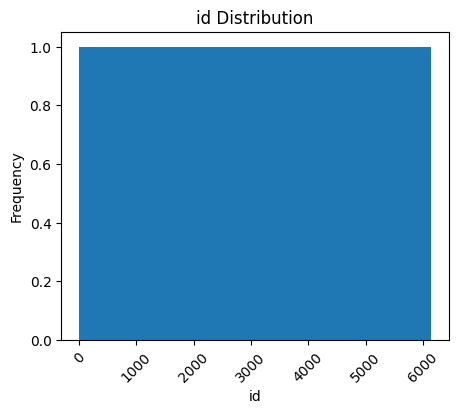

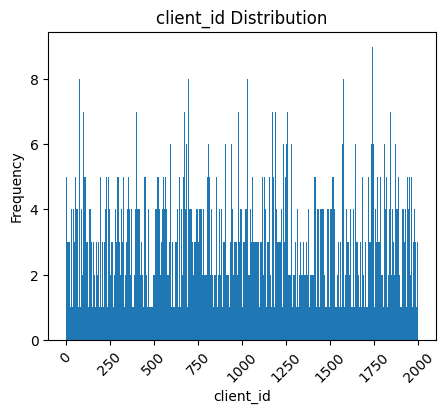

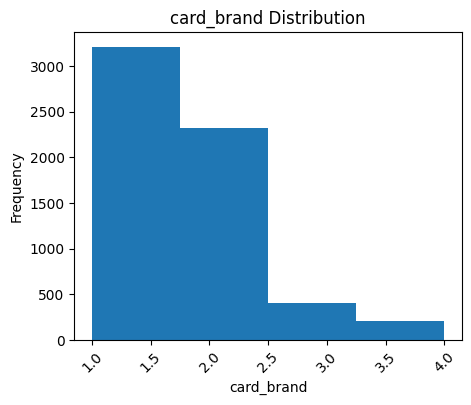

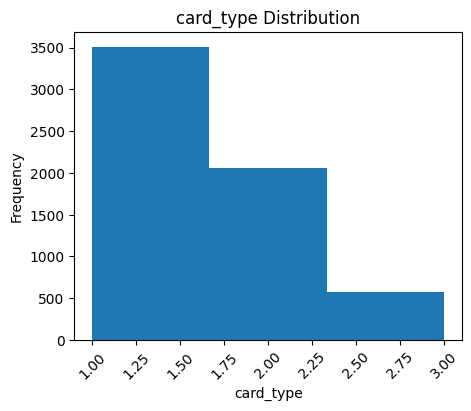

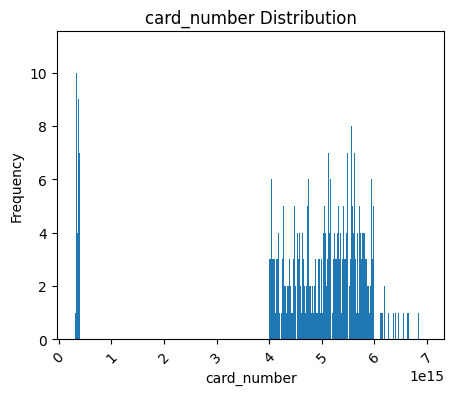

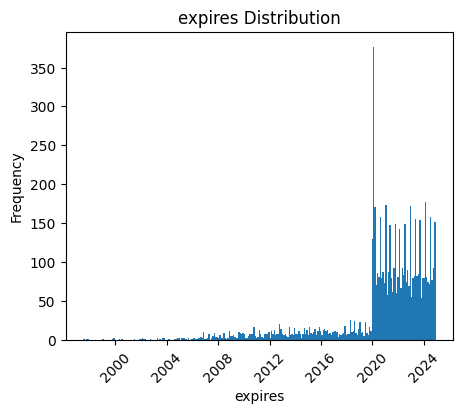

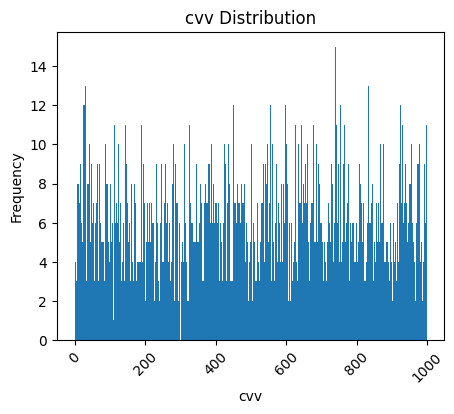

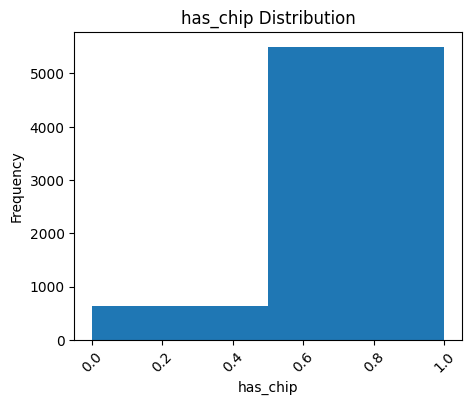

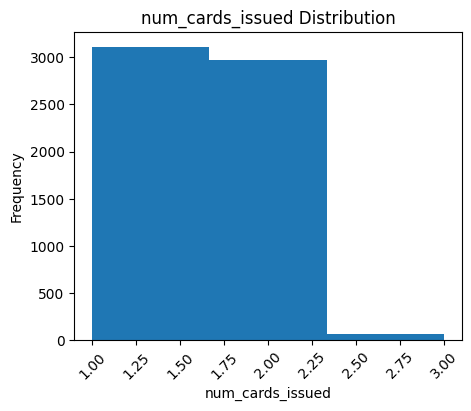

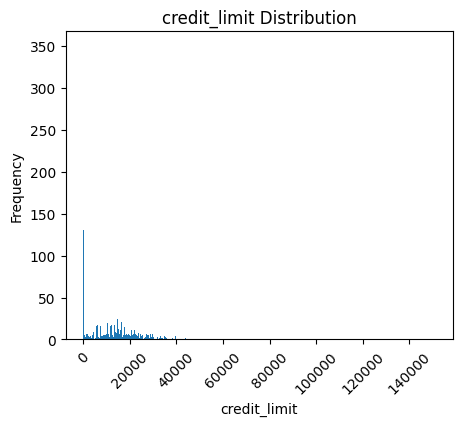

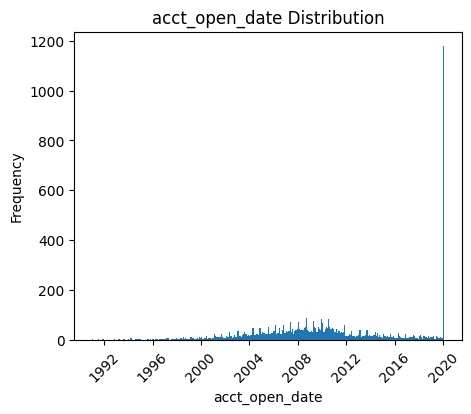

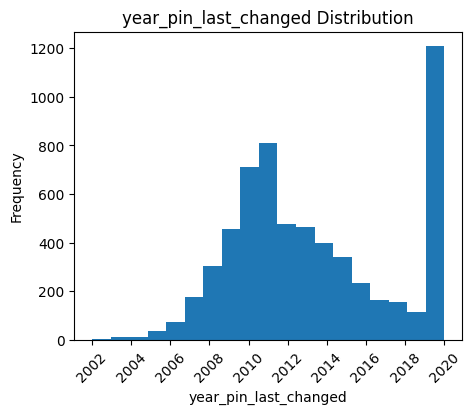

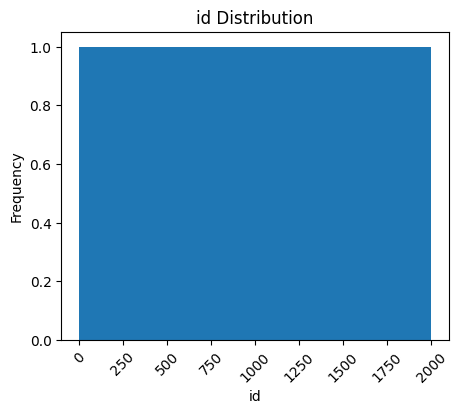

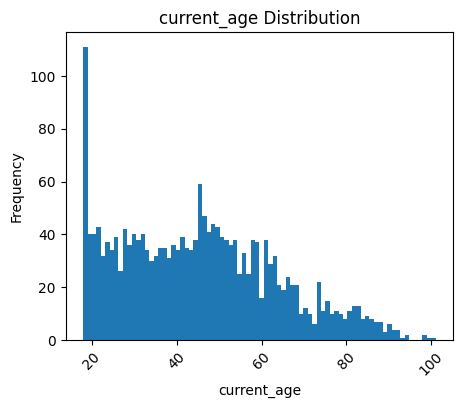

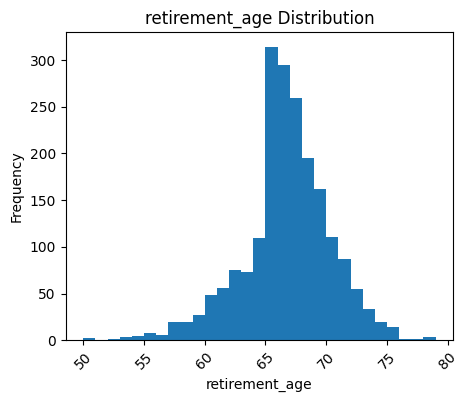

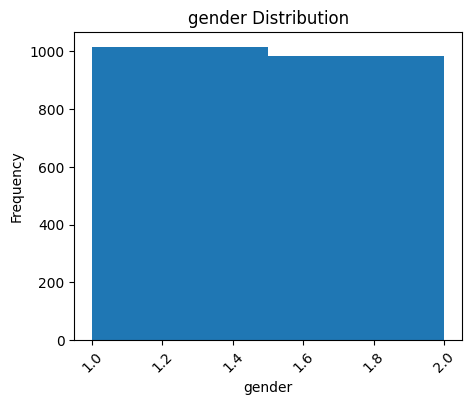

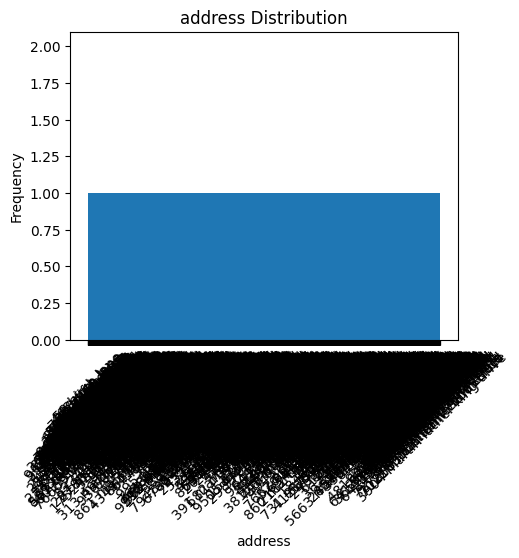

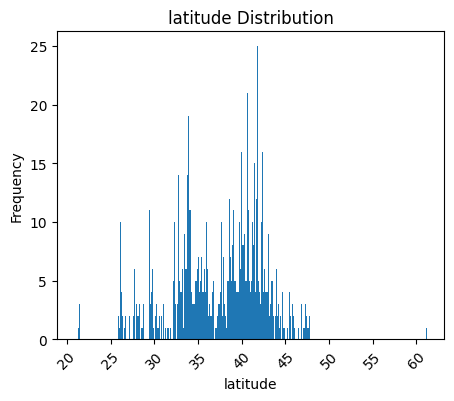

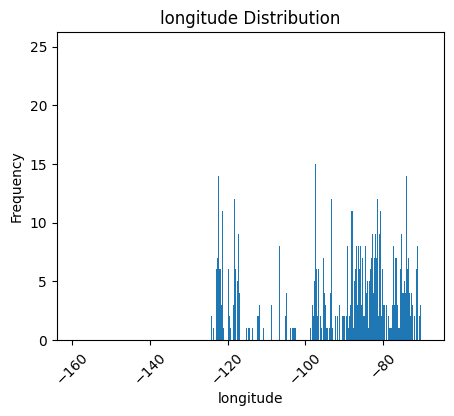

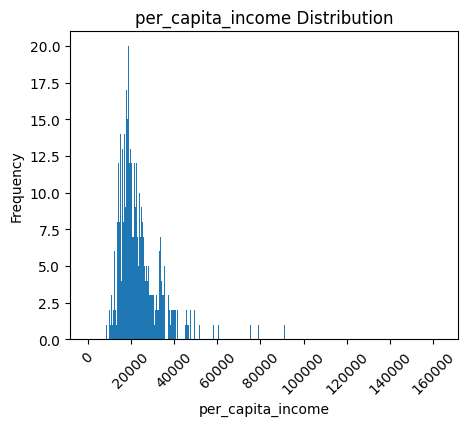

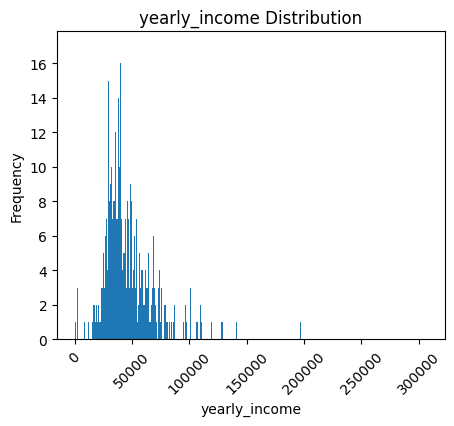

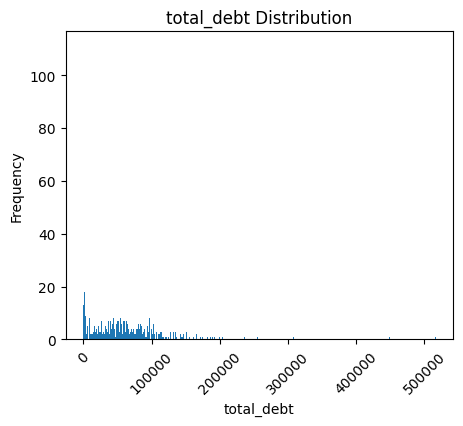

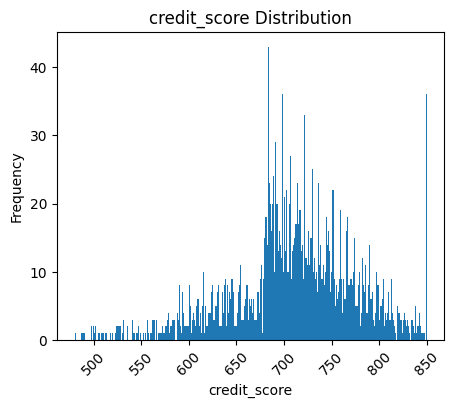

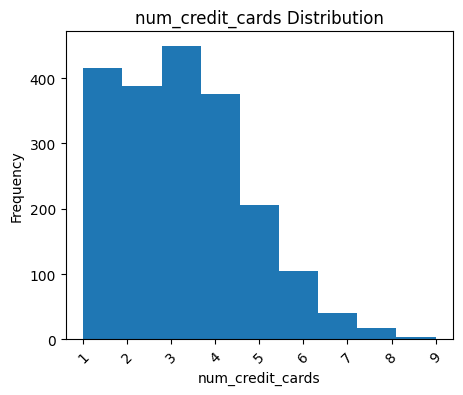

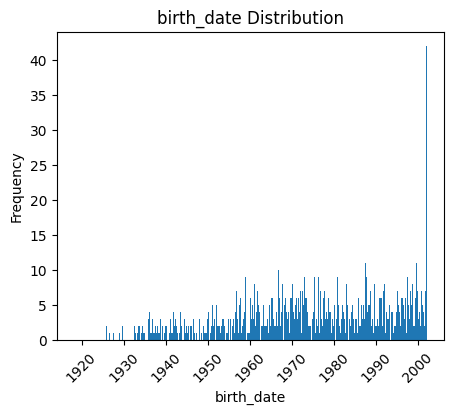

In [ ]:
# for dataset in datasets_final:
#     if dataset.equals(df_transactions_final):
#         continue
#     for col in dataset.columns:
#         plt.figure(figsize = (5,4))
#         plt.hist(dataset[col].dropna(), bins = dataset[col].nunique())
#         plt.title(f'{col} Distribution')
#         plt.xticks(rotation = 45)
#         plt.xlabel(col)
#         plt.ylabel('Frequency')
#         plt.show()

### Correlation

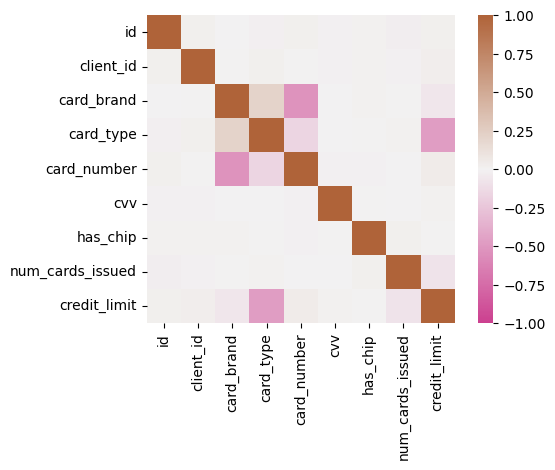

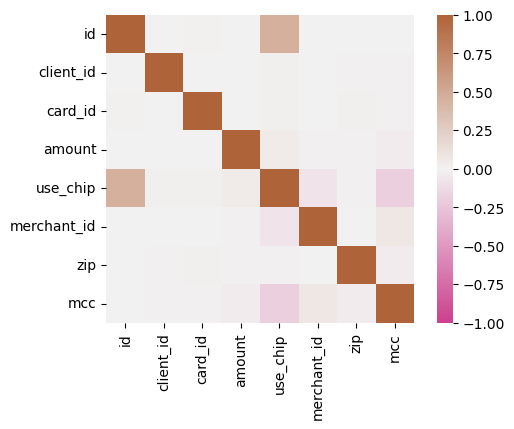

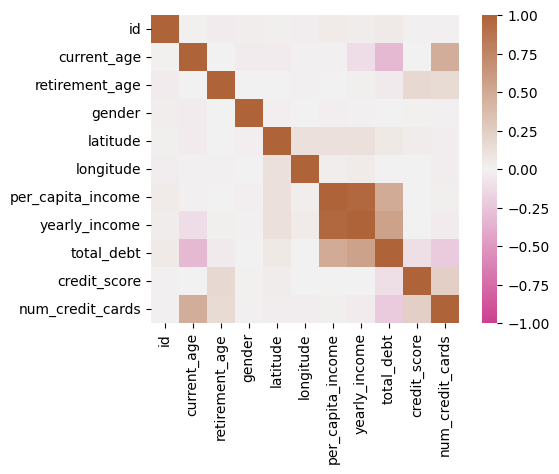

In [ ]:
# for dataset in datasets_final:
#     corr = dataset.corr(numeric_only = True)
#     f, ax = plt.subplots(figsize=(6, 4))
#     sns.heatmap(corr, cmap=sns.diverging_palette(340, 30, as_cmap=True), vmin=-1.0, vmax=1.0, square=True, ax=ax)

### Pairwise Plots

In [ ]:
# for dataset in datasets_final:
#     # if dataset.equals(df_transactions_final):
#     #     continue
#     filtered_cols = dataset.columns[dataset.nunique() < 5]
#     for col in filtered_cols:
#         g = sns.pairplot(dataset, hue = col)
#     plt.show()

### Line Graphs for Trended Views - TO DO

#### Events

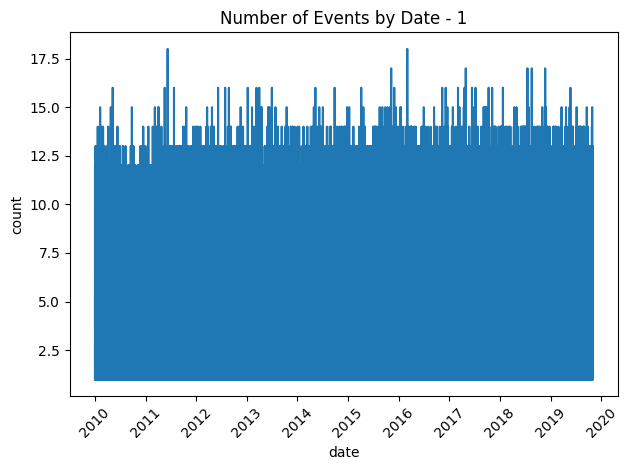

In [ ]:
# for i, dataset in enumerate(datasets_final):
#     if dataset.columns.__contains__('date'):
#         df_counts = dataset.groupby('date').size().reset_index(name='count')

#         sns.lineplot(data=df_counts, x='date', y='count')
#         plt.xticks(rotation=45)
#         plt.title(f'Number of Events by Date - {i}')
#         plt.tight_layout()

#         plt.show()

## Merge Datasets

In [59]:
# Try 2 things:
# 1) Complete dataframe with all data
# 2) Keep as separate datasets and use feeder function to join as the data gets fed into the algorithmS

In [60]:
df_transactions_merge = df_transactions_final.copy()
df_cards_merge = df_cards_final.copy()
df_users_merge = df_users_final.copy()

In [61]:
# Rename join columns to be consistent
df_users_merge = df_users_merge.rename(columns={'id': 'client_id'})
df_cards_merge = df_cards_merge.rename(columns={'id': 'card_id'})

# Drop client_id column from cards data
df_cards_merge = df_cards_merge.drop('client_id', axis = 1)

# Merge dataframes
df_merged = df_transactions_merge.merge(df_cards_merge, how='left', on='card_id')

# Use the client_id from transactions (client_id_x)
df_merged = df_merged.merge(df_users_merge, how='left', on='client_id')

#Convert fraud labels index into integer before attempting to merge
df_fraud_labels.index = df_fraud_labels.index.astype(int)

# Add fraud labels
df_merged = df_merged.merge(df_fraud_labels, how='left', left_on='id', right_index = True)

# Map MCC codes to category names
df_merged['merchant_category'] = df_merged['mcc'].astype(str).map(data_mcc_codes)
df_merged = df_merged.drop('mcc', axis = 1)

In [62]:
df_merged.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'errors',
       'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'current_age', 'retirement_age', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'birth_date', 'target', 'merchant_category'],
      dtype='object')

In [63]:
df_merged.merchant_category.unique()

array(['Miscellaneous Food Stores', 'Department Stores', 'Money Transfer',
       'Drinking Places (Alcoholic Beverages)', 'Book Stores',
       'Tolls and Bridge Fees', 'Athletic Fields, Commercial Sports',
       'Grocery Stores, Supermarkets', 'Taxicabs and Limousines',
       'Service Stations', 'Automotive Service Shops', 'Wholesale Clubs',
       'Package Stores, Beer, Wine, Liquor',
       'Upholstery and Drapery Stores', 'Fast Food Restaurants',
       'Discount Stores', 'Telecommunication Services',
       'Utilities - Electric, Gas, Water, Sanitary',
       'Eating Places and Restaurants',
       'Betting (including Lottery Tickets, Casinos)',
       'Recreational Sports, Clubs', 'Drug Stores and Pharmacies',
       'Lodging - Hotels, Motels, Resorts',
       'Books, Periodicals, Newspapers',
       'Detective Agencies, Security Services', 'Family Clothing Stores',
       'Computer Network Services', 'Theatrical Producers',
       'Digital Goods - Media, Books, Apps',
       

In [64]:
df_merged.date.unique()

<DatetimeArray>
['2010-01-01 00:01:00', '2010-01-01 00:02:00', '2010-01-01 00:05:00',
 '2010-01-01 00:06:00', '2010-01-01 00:07:00', '2010-01-01 00:09:00',
 '2010-01-01 00:14:00', '2010-01-01 00:21:00', '2010-01-01 00:23:00',
 '2010-01-01 00:26:00',
 ...
 '2019-10-31 23:46:00', '2019-10-31 23:49:00', '2019-10-31 23:51:00',
 '2019-10-31 23:52:00', '2019-10-31 23:54:00', '2019-10-31 23:55:00',
 '2019-10-31 23:56:00', '2019-10-31 23:57:00', '2019-10-31 23:58:00',
 '2019-10-31 23:59:00']
Length: 4136496, dtype: datetime64[ns]

In [65]:
df_merged.year_pin_last_changed.unique()

<DatetimeArray>
['2008-01-01 00:00:00', '2015-01-01 00:00:00', '2006-01-01 00:00:00',
 '2014-01-01 00:00:00', '2012-01-01 00:00:00', '2011-01-01 00:00:00',
 '2010-01-01 00:00:00', '2009-01-01 00:00:00', '2019-01-01 00:00:00',
 '2003-01-01 00:00:00', '2007-01-01 00:00:00', '2016-01-01 00:00:00',
 '2013-01-01 00:00:00', '2005-01-01 00:00:00', '2017-01-01 00:00:00',
 '2020-01-01 00:00:00', '2018-01-01 00:00:00', '2004-01-01 00:00:00',
 '2002-01-01 00:00:00']
Length: 19, dtype: datetime64[ns]

In [66]:
df_merged.year_pin_last_changed.dtype

dtype('<M8[ns]')

In [67]:
df_merged.acct_open_date.unique()

<DatetimeArray>
['2008-05-01 00:00:00', '2005-09-01 00:00:00', '2006-01-01 00:00:00',
 '2004-05-01 00:00:00', '2009-07-01 00:00:00', '2008-01-01 00:00:00',
 '2007-03-01 00:00:00', '2008-10-01 00:00:00', '2007-02-01 00:00:00',
 '2006-10-01 00:00:00',
 ...
 '2018-11-01 00:00:00', '2018-12-01 00:00:00', '2019-02-01 00:00:00',
 '2019-03-01 00:00:00', '2019-08-01 00:00:00', '2019-05-01 00:00:00',
 '2019-07-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00',
 '2019-12-01 00:00:00']
Length: 295, dtype: datetime64[ns]

In [68]:
df_merged.acct_open_date.dtype

dtype('<M8[ns]')

In [69]:
df_merged.birth_date.unique()

<DatetimeArray>
['1989-07-01 00:00:00', '1971-06-01 00:00:00', '1970-04-01 00:00:00',
 '1967-05-01 00:00:00', '1968-05-01 00:00:00', '1972-12-01 00:00:00',
 '1963-11-01 00:00:00', '1973-07-01 00:00:00', '1928-09-01 00:00:00',
 '1960-08-01 00:00:00',
 ...
 '1993-01-01 00:00:00', '1993-08-01 00:00:00', '1995-12-01 00:00:00',
 '1995-01-01 00:00:00', '1989-08-01 00:00:00', '1995-06-01 00:00:00',
 '1996-10-01 00:00:00', '1987-02-01 00:00:00', '1994-04-01 00:00:00',
 '1953-11-01 00:00:00']
Length: 572, dtype: datetime64[ns]

In [70]:
df_merged.birth_date.dtype

dtype('<M8[ns]')

## Feature Engineering

### Temporal Features

In [71]:
# Date column - minute level
df_merged['txn_hour'] = df_merged['date'].dt.hour
df_merged['txn_minute'] = df_merged['date'].dt.minute
df_merged['txn_year'] = df_merged['date'].dt.year
df_merged['txn_month'] = df_merged['date'].dt.month
df_merged['txn_day'] = df_merged['date'].dt.day
df_merged['txn_day_of_week'] = df_merged['date'].dt.dayofweek
df_merged = df_merged.drop('date', axis = 1)

# Year PIN last changed column - year level
df_merged['year_pin_last_changed'] = df_merged['year_pin_last_changed'].dt.year

# Account open date column - day level
df_merged['acct_open_year'] = df_merged['acct_open_date'].dt.year
df_merged['acct_open_month'] = df_merged['acct_open_date'].dt.month
df_merged['acct_open_day'] = df_merged['acct_open_date'].dt.day
df_merged['acct_open_day_of_week'] = df_merged['acct_open_date'].dt.dayofweek
df_merged = df_merged.drop('acct_open_date', axis = 1)

# Birth date column - day level
df_merged['birth_year'] = df_merged['birth_date'].dt.year
df_merged['birth_month'] = df_merged['birth_date'].dt.month
df_merged['birth_day'] = df_merged['birth_date'].dt.day
df_merged = df_merged.drop('birth_date', axis = 1)

In [72]:
df_merged

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,txn_month,txn_day,txn_day_of_week,acct_open_year,acct_open_month,acct_open_day,acct_open_day_of_week,birth_year,birth_month,birth_day
0,7475327,1556,2972,-77.00,1,59935,beulah,nd,58523.0,NaN,...,1,1,4,2008,5,1,3,1989,7,1
1,7475328,561,4575,14.57,1,67570,bettendorf,ia,52722.0,NaN,...,1,1,4,2005,9,1,3,1971,6,1
2,7475329,1129,102,80.00,1,27092,vista,ca,92084.0,NaN,...,1,1,4,2006,1,1,6,1970,4,1
3,7475331,430,2860,200.00,1,27092,crown point,in,46307.0,NaN,...,1,1,4,2004,5,1,5,1967,5,1
4,7475332,848,3915,46.41,1,13051,harwood,md,20776.0,NaN,...,1,1,4,2009,7,1,2,1968,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,1718,2379,1.11,2,86438,west covina,ca,91792.0,NaN,...,10,31,3,2019,3,1,4,1938,11,1
13305911,23761869,1766,2066,12.80,3,39261,online,NaN,NaN,NaN,...,10,31,3,2004,3,1,0,1957,9,1
13305912,23761870,199,1031,40.44,1,2925,allen,tx,75002.0,NaN,...,10,31,3,2004,2,1,6,1952,4,1
13305913,23761873,1986,5443,4.00,2,46284,daly city,ca,94014.0,NaN,...,10,31,3,2005,11,1,1,1975,12,1


### Amount-based Features

In [73]:
# df_merged['log_amount'] = np.log1p(df_merged['amount'])
# df_merged['log_credit_limit'] = np.log1p(df_merged['credit_limit'])
# df_merged['log_per_capita_income'] = np.log1p(df_merged['per_capita_income'])
# df_merged['log_yearly_income'] = np.log1p(df_merged['yearly_income'])
# df_merged['log_total_debt'] = np.log1p(df_merged['total_debt'])
# df_merged = df_merged.drop(['amount', 'credit_limit', 'per_capita_income', 'yearly_income', 'total_debt'], axis = 1)

In [74]:
df_merged

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,txn_month,txn_day,txn_day_of_week,acct_open_year,acct_open_month,acct_open_day,acct_open_day_of_week,birth_year,birth_month,birth_day
0,7475327,1556,2972,-77.00,1,59935,beulah,nd,58523.0,NaN,...,1,1,4,2008,5,1,3,1989,7,1
1,7475328,561,4575,14.57,1,67570,bettendorf,ia,52722.0,NaN,...,1,1,4,2005,9,1,3,1971,6,1
2,7475329,1129,102,80.00,1,27092,vista,ca,92084.0,NaN,...,1,1,4,2006,1,1,6,1970,4,1
3,7475331,430,2860,200.00,1,27092,crown point,in,46307.0,NaN,...,1,1,4,2004,5,1,5,1967,5,1
4,7475332,848,3915,46.41,1,13051,harwood,md,20776.0,NaN,...,1,1,4,2009,7,1,2,1968,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,1718,2379,1.11,2,86438,west covina,ca,91792.0,NaN,...,10,31,3,2019,3,1,4,1938,11,1
13305911,23761869,1766,2066,12.80,3,39261,online,NaN,NaN,NaN,...,10,31,3,2004,3,1,0,1957,9,1
13305912,23761870,199,1031,40.44,1,2925,allen,tx,75002.0,NaN,...,10,31,3,2004,2,1,6,1952,4,1
13305913,23761873,1986,5443,4.00,2,46284,daly city,ca,94014.0,NaN,...,10,31,3,2005,11,1,1,1975,12,1


### Frequency Features

In [75]:
txn_counts = df_merged.groupby('client_id')['id'].count()
df_merged['client_txn_count'] = df_merged['client_id'].map(txn_counts)

txn_counts = df_merged.groupby('card_id')['id'].count()
df_merged['card_txn_count'] = df_merged['card_id'].map(txn_counts)

txn_counts = df_merged.groupby('client_id')['id'].count()
df_merged['client_card_count'] = df_merged['client_id'].map(txn_counts)

In [76]:
df_merged

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,acct_open_year,acct_open_month,acct_open_day,acct_open_day_of_week,birth_year,birth_month,birth_day,client_txn_count,card_txn_count,client_card_count
0,7475327,1556,2972,-77.00,1,59935,beulah,nd,58523.0,NaN,...,2008,5,1,3,1989,7,1,5170,1631,5170
1,7475328,561,4575,14.57,1,67570,bettendorf,ia,52722.0,NaN,...,2005,9,1,3,1971,6,1,11762,3918,11762
2,7475329,1129,102,80.00,1,27092,vista,ca,92084.0,NaN,...,2006,1,1,6,1970,4,1,14444,6655,14444
3,7475331,430,2860,200.00,1,27092,crown point,in,46307.0,NaN,...,2004,5,1,5,1967,5,1,20998,6638,20998
4,7475332,848,3915,46.41,1,13051,harwood,md,20776.0,NaN,...,2009,7,1,2,1968,5,1,6614,3603,6614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,1718,2379,1.11,2,86438,west covina,ca,91792.0,NaN,...,2019,3,1,4,1938,11,1,25890,348,25890
13305911,23761869,1766,2066,12.80,3,39261,online,NaN,NaN,NaN,...,2004,3,1,0,1957,9,1,4075,909,4075
13305912,23761870,199,1031,40.44,1,2925,allen,tx,75002.0,NaN,...,2004,2,1,6,1952,4,1,10144,5353,10144
13305913,23761873,1986,5443,4.00,2,46284,daly city,ca,94014.0,NaN,...,2005,11,1,1,1975,12,1,7045,3523,7045


### One-hot Encoding

In [77]:
df_merged['merchant_category'] = df_merged['merchant_category'].astype('category').cat.codes

In [78]:
df_merged['merchant_category'].dtype

dtype('int8')

In [79]:
df_merged['merchant_category'].unique()

array([ 64,  26,  70,  32,  12,  99,   5,  45,  96,  87,   8, 106,  77,
       103,  39,  30,  97, 104,  34,  10,  85,  33,  60,  13,  27,  38,
        21,  98,  29,  16,   9,  91,  35,   3,   4, 102,  14,  19,  62,
         2,  46,  78,  75,  53,  61, 107,  59,  74,  84,  72,  66,  43,
        41,  82,  15,  65,  89,  56,  51,  71,  69, 105,  81,  88,  42,
        44,  23, 100,  58,  36,  83,  86,  68,  49,  79,  25,  52,  76,
        80,  17,  54,  57,  31,  18,  55,   0,  48,  95,  28,   6,  93,
        47,   1,   7,  94, 101,  37,  11,  67,  92,  24,  20,  22,  40,
        90,  73,  63,  50], dtype=int8)

In [80]:
df_merged = pd.get_dummies(df_merged, columns=['merchant_category'], drop_first = True)

In [81]:
df_merged

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,merchant_category_98,merchant_category_99,merchant_category_100,merchant_category_101,merchant_category_102,merchant_category_103,merchant_category_104,merchant_category_105,merchant_category_106,merchant_category_107
0,7475327,1556,2972,-77.00,1,59935,beulah,nd,58523.0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,7475328,561,4575,14.57,1,67570,bettendorf,ia,52722.0,NaN,...,False,False,False,False,False,False,False,False,False,False
2,7475329,1129,102,80.00,1,27092,vista,ca,92084.0,NaN,...,False,False,False,False,False,False,False,False,False,False
3,7475331,430,2860,200.00,1,27092,crown point,in,46307.0,NaN,...,False,False,False,False,False,False,False,False,False,False
4,7475332,848,3915,46.41,1,13051,harwood,md,20776.0,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,1718,2379,1.11,2,86438,west covina,ca,91792.0,NaN,...,False,False,False,False,False,False,False,False,False,False
13305911,23761869,1766,2066,12.80,3,39261,online,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
13305912,23761870,199,1031,40.44,1,2925,allen,tx,75002.0,NaN,...,False,False,False,False,False,False,True,False,False,False
13305913,23761873,1986,5443,4.00,2,46284,daly city,ca,94014.0,NaN,...,False,False,False,False,False,False,False,False,False,False


## Imputation

In [81]:
# # Select only numeric columns for imputation (which OneClassSVM will use)
# X_numeric = df_merged.select_dtypes(include=[np.number])

# # Step 1: Create the kernel (imputation model)
# kernel = mf.ImputationKernel(
#     X_numeric,
#     # save_all_iterations=True,
#     random_state=42
# )

# # Step 2: Run the MICE algorithm for a few iterations (default 5–10 is typical)
# kernel.mice(2)

# # Step 3: Extract the completed (imputed) dataset
# X_imputed = kernel.complete_data()

In [82]:
# X_imputed.to_csv('imputed_data.csv', index = True)

In [83]:
# Update df_merged to reflect imputed values
# df_merged[X_imputed.columns] = X_imputed

In [84]:
# df_merged.to_csv('imputed_data_merged.csv', index = True)

## Anomaly Detection

In [90]:
df_merged.shape

(13305915, 155)

In [84]:
# Select only numerical columns
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns

# Filter rows where all numeric columns are non-null (no NaNs)
df_no_nans = df_merged[df_merged[numeric_cols].notna().all(axis=1)]

df_no_nans

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,merchant_category_98,merchant_category_99,merchant_category_100,merchant_category_101,merchant_category_102,merchant_category_103,merchant_category_104,merchant_category_105,merchant_category_106,merchant_category_107
0,7475327,1556,2972,-77.00,1,59935,beulah,nd,58523.0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,7475328,561,4575,14.57,1,67570,bettendorf,ia,52722.0,NaN,...,False,False,False,False,False,False,False,False,False,False
2,7475329,1129,102,80.00,1,27092,vista,ca,92084.0,NaN,...,False,False,False,False,False,False,False,False,False,False
4,7475332,848,3915,46.41,1,13051,harwood,md,20776.0,NaN,...,False,False,False,False,False,False,False,False,False,False
5,7475333,1807,165,4.81,1,20519,bronx,ny,10464.0,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305904,23761861,234,5178,40.00,1,27092,dallas,tx,75208.0,NaN,...,False,False,False,False,False,False,False,False,False,False
13305905,23761862,672,5001,12.93,2,47508,cosby,tn,37722.0,NaN,...,False,False,False,False,False,False,False,False,False,False
13305906,23761863,1384,3723,67.01,2,58136,williamson,ga,30292.0,NaN,...,False,False,False,False,False,False,False,False,False,False
13305910,23761868,1718,2379,1.11,2,86438,west covina,ca,91792.0,NaN,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
anomaly_detector = IsolationForest(contamination=0.01, random_state=42)

df_no_nans['anomaly_score'] = anomaly_detector.fit_predict(df_no_nans[numeric_cols])

# # Assign predicted anomaly scores back into original df_merged using the index
df_merged.loc[df_no_nans.index, 'anomaly_score'] = df_no_nans['anomaly_score']

C:\Users\arrab\AppData\Local\Temp\ipykernel_40496\1796384946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nans['anomaly_score'] = anomaly_detector.fit_predict(df_no_nans[numeric_cols])


In [ ]:
# # Fit and predict anomaly score on clean subset of df_merged
# anomaly_detector_svm = OneClassSVM()
# df_no_nans['anomaly_score_svm'] = anomaly_detector_svm.fit_predict(df_no_nans[numeric_cols])

# # Assign predicted anomaly scores back into original df_merged using the index
# df_merged.loc[df_no_nans.index, 'anomaly_score_svm'] = df_no_nans['anomaly_score_svm']

In [86]:
df_merged[df_merged['anomaly_score'] == -1]

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,merchant_category_99,merchant_category_100,merchant_category_101,merchant_category_102,merchant_category_103,merchant_category_104,merchant_category_105,merchant_category_106,merchant_category_107,anomaly_score
32,7475362,1357,4488,14.57,1,78632,tacoma,wa,98404.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
51,7475383,1357,65,23.08,1,80797,tacoma,wa,98404.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
403,7475794,1963,4565,4.60,1,78854,vacaville,ca,95687.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
441,7475837,14,5159,9.44,1,92883,waipahu,hi,96797.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
704,7476159,705,5359,31.02,1,13646,walnut creek,ca,94598.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305683,23761583,708,5165,154.00,2,81829,new york,ny,10075.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
13305766,23761688,1811,4894,56.50,2,25717,menlo park,ca,94025.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
13305836,23761775,1168,3239,-78.00,2,61195,berkeley heights,nj,7922.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0
13305838,23761778,1168,3239,61.87,2,61195,berkeley heights,nj,7922.0,NaN,...,False,False,False,False,False,False,False,False,False,-1.0


In [ ]:
# df_merged[df_merged['anomaly_score_svm'] == -1]

In [87]:
# Drop clear outliers
df_clean = df_merged[df_merged['anomaly_score'] != -1].copy()

In [89]:
df_clean.shape

(13227839, 155)

In [97]:
df_clean[df_clean['target'].isna() == True]

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,...,merchant_category_99,merchant_category_100,merchant_category_101,merchant_category_102,merchant_category_103,merchant_category_104,merchant_category_105,merchant_category_106,merchant_category_107,anomaly_score
3,7475331,430,2860,200.00,1,27092,crown point,in,46307.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
6,7475334,1556,2972,77.00,1,59935,beulah,nd,58523.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
8,7475336,335,5131,261.58,3,50292,online,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN
9,7475337,351,1112,10.74,1,3864,flushing,ny,11355.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
15,7475343,1634,2464,1.09,1,20519,san benito,tx,78586.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305907,23761864,374,4567,11.43,2,68147,sacramento,ca,95823.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
13305908,23761865,1475,1177,57.22,2,11468,ewa beach,hi,96706.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
13305909,23761867,1421,3550,165.09,2,30286,winterville,nc,28590.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN
13305913,23761873,1986,5443,4.00,2,46284,daly city,ca,94014.0,NaN,...,False,False,False,False,False,False,False,False,False,NaN


## Hybrid Resampling

In [92]:
X = df_clean.drop(['target', 'id', 'client_id', 'card_id', 'merchant_id', 'card_number', 'cvv','errors', 'address', 'anomaly_score'], axis=1)
y = df_clean['target']

resample_pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('oversample', SMOTE(sampling_strategy=0.5))
])
X_resampled, y_resampled = resample_pipeline.fit_resample(X, y)

c:\Users\arrab\Documents\Career\MSc Data Science\COMM424DA - MSc Project\Datasets\Financial Transactions\fraud\Lib\site-packages\sklearn\utils\_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y contains NaN.

In [ ]:
X_resampled

In [ ]:
y_resampled

## Train-Test Split & Cross Valdation

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.4, stratify=y_resampled, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Model Deployment

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, average_precision_score
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense,
    LSTM, Concatenate, Dropout
)
from tensorflow.keras.utils import to_categorical

# Sample setup (data will be replaced with actual processed features)
np.random.seed(42)

# Simulate preprocessed dataset
n_samples = 1000
n_features = 20
timesteps = 10

X_cnn = np.random.rand(n_samples, n_features, 1)       # For CNN
X_lstm = np.random.rand(n_samples, timesteps, 1)       # For LSTM
y = np.random.randint(0, 2, size=n_samples)            # Binary target

# Split for training and testing
X_cnn_train, X_cnn_test, X_lstm_train, X_lstm_test, y_train, y_test = train_test_split(
    X_cnn, X_lstm, y, test_size=0.4, stratify=y, random_state=42
)

# CNN Branch
cnn_input = Input(shape=(n_features, 1))
cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
cnn = Flatten()(cnn)

# LSTM Branch
lstm_input = Input(shape=(timesteps, 1))
lstm = LSTM(64, return_sequences=False)(lstm_input)

# Fusion
merged = Concatenate()([cnn, lstm])
dense = Dense(64, activation='relu')(merged)
drop = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(drop)

model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit([X_cnn_train, X_lstm_train], y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

# Get intermediate output (meta-features)
meta_features_train = model.predict([X_cnn_train, X_lstm_train])
meta_features_test = model.predict([X_cnn_test, X_lstm_test])

# XGBoost with meta-features
xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(meta_features_train, y_train)

# Evaluation
y_pred = xgb_model.predict(meta_features_test)
f1 = f1_score(y_test, y_pred)
auprc = average_precision_score(y_test, xgb_model.predict_proba(meta_features_test)[:, 1])

f1, auprc
